# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = 'Scene1-LSTM2'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 60

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=1, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=1, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(55167, 57167)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([60, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([60, 6])

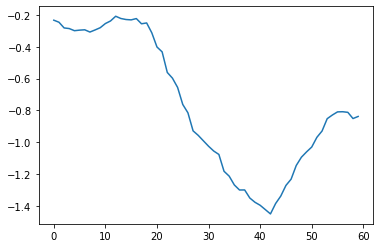

In [10]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [11]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=24,
                           num_layers=8,
                           dropout=0.1,
                           bidirectional=True).cuda()

In [12]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [13]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [14]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [15]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [ ]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.077783
 - Pitch        :  10.601428
 - Roll         :   3.086130
 - RMS          :   8.252688
 - 99% Tile     :  42.293835
Save output signals into checkpoint/Scene1-LSTM2/sample/0001.npy


[0003/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.765939
 - Pitch        :   8.372552
 - Roll         :   3.070440
 - RMS          :   7.219624
 - 99% Tile     :  37.459354
Save output signals into checkpoint/Scene1-LSTM2/sample/0002.npy


[0004/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.172045
 - Pitch        :   6.622475
 - Roll         :   2.973968
 - RMS          :   5.501388
 - 99% Tile     :  33.475121
Save output signals into checkpoint/Scene1-LSTM2/sample/0003.npy


[0005/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.370397
 - Pitch        :   5.225002
 - Roll         :   2.969529
 - RMS          :   4.290265
 - 99% Tile     :  30.013702
Save output signals into checkpoint/Scene1-LSTM2/sample/0004.npy


[0006/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.554574
 - Pitch        :   4.038747
 - Roll         :   2.902471
 - RMS          :   3.529438
 - 99% Tile     :  26.840424
Save output signals into checkpoint/Scene1-LSTM2/sample/0005.npy


[0007/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.963082
 - Pitch        :   3.087537
 - Roll         :   2.802339
 - RMS          :   2.953294
 - 99% Tile     :  23.732456
Save output signals into checkpoint/Scene1-LSTM2/sample/0006.npy


[0008/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.492846
 - Pitch        :   2.686671
 - Roll         :   2.541028
 - RMS          :   2.574834
 - 99% Tile     :  21.281820
Save output signals into checkpoint/Scene1-LSTM2/sample/0007.npy


[0009/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.451383
 - Pitch        :   2.453016
 - Roll         :   2.231766
 - RMS          :   2.380990
 - 99% Tile     :  18.967091
Save output signals into checkpoint/Scene1-LSTM2/sample/0008.npy


[0010/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.804800
 - Pitch        :   1.988465
 - Roll         :   1.832157
 - RMS          :   1.876885
 - 99% Tile     :  16.590652
Save output signals into checkpoint/Scene1-LSTM2/sample/0009.npy


[0011/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.630928
 - Pitch        :   1.900932
 - Roll         :   1.639262
 - RMS          :   1.728260
 - 99% Tile     :  14.991459
Save output signals into checkpoint/Scene1-LSTM2/sample/0010.npy


[0012/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.452608
 - Pitch        :   1.743327
 - Roll         :   1.490945
 - RMS          :   1.567607
 - 99% Tile     :  13.878532
Save output signals into checkpoint/Scene1-LSTM2/sample/0011.npy


[0013/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.482659
 - Pitch        :   1.632403
 - Roll         :   1.362599
 - RMS          :   1.496629
 - 99% Tile     :  13.173480
Save output signals into checkpoint/Scene1-LSTM2/sample/0012.npy


[0014/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.350510
 - Pitch        :   1.683921
 - Roll         :   1.305346
 - RMS          :   1.456411
 - 99% Tile     :  12.905151
Save output signals into checkpoint/Scene1-LSTM2/sample/0013.npy


[0015/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.377744
 - Pitch        :   1.381131
 - Roll         :   1.306958
 - RMS          :   1.355709
 - 99% Tile     :  12.556372
Save output signals into checkpoint/Scene1-LSTM2/sample/0014.npy


[0016/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.286640
 - Pitch        :   1.421262
 - Roll         :   1.143563
 - RMS          :   1.288819
 - 99% Tile     :  11.849131
Save output signals into checkpoint/Scene1-LSTM2/sample/0015.npy


[0017/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.161102
 - Pitch        :   1.307732
 - Roll         :   1.153745
 - RMS          :   1.209607
 - 99% Tile     :  11.618811
Save output signals into checkpoint/Scene1-LSTM2/sample/0016.npy


[0018/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.369673
 - Pitch        :   1.247259
 - Roll         :   1.176304
 - RMS          :   1.266932
 - 99% Tile     :  11.578972
Save output signals into checkpoint/Scene1-LSTM2/sample/0017.npy


[0019/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.315444
 - Pitch        :   1.348760
 - Roll         :   1.192754
 - RMS          :   1.287402
 - 99% Tile     :  11.232961
Save output signals into checkpoint/Scene1-LSTM2/sample/0018.npy


[0020/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.018420
 - Pitch        :   1.133428
 - Roll         :   1.043280
 - RMS          :   1.066188
 - 99% Tile     :  10.897938
Save output signals into checkpoint/Scene1-LSTM2/sample/0019.npy


[0021/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.081089
 - Pitch        :   1.121155
 - Roll         :   1.019278
 - RMS          :   1.074658
 - 99% Tile     :  10.475988
Save output signals into checkpoint/Scene1-LSTM2/sample/0020.npy


[0022/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.109530
 - Pitch        :   1.262259
 - Roll         :   1.057664
 - RMS          :   1.146445
 - 99% Tile     :  10.258299
Save output signals into checkpoint/Scene1-LSTM2/sample/0021.npy


[0023/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.053655
 - Pitch        :   1.172550
 - Roll         :   1.056813
 - RMS          :   1.095737
 - 99% Tile     :  10.493505
Save output signals into checkpoint/Scene1-LSTM2/sample/0022.npy


[0024/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.014135
 - Pitch        :   1.119710
 - Roll         :   0.995100
 - RMS          :   1.044421
 - 99% Tile     :  10.034706
Save output signals into checkpoint/Scene1-LSTM2/sample/0023.npy


[0025/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.073858
 - Pitch        :   1.123342
 - Roll         :   0.960786
 - RMS          :   1.054858
 - 99% Tile     :   9.962172
Save output signals into checkpoint/Scene1-LSTM2/sample/0024.npy


[0026/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.899150
 - Pitch        :   1.140846
 - Roll         :   0.970852
 - RMS          :   1.008721
 - 99% Tile     :   9.996721
Save output signals into checkpoint/Scene1-LSTM2/sample/0025.npy


[0027/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.877526
 - Pitch        :   1.004750
 - Roll         :   0.982141
 - RMS          :   0.956412
 - 99% Tile     :  10.111685
Save output signals into checkpoint/Scene1-LSTM2/sample/0026.npy


[0028/0100] Train:   0%|                                                    | 0/216 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.062625
 - Pitch        :   0.996466
 - Roll         :   0.958078
 - RMS          :   1.006650
 - 99% Tile     :  10.212240
Save output signals into checkpoint/Scene1-LSTM2/sample/0027.npy


[0028/0100] Validation:  24%|█████                | 54/224 [00:01<00:08, 19.55it/s, val_loss 9.1077]